# Árboles de decisión y k-vecinos más cercanos

En este notebook trabajaremos con los dos modelos fundamentales de Machine Learning, Árboles de Decisión y k-vecinos más cercanos (kNN, k-nearest neighbors). Para ello, seguiremos utilizando el Iris Dataset y, luego, usaremos uno nuevo, el dataset de Titanic. El notebook está dividido en tres partes: 

1. kNN con Iris Dataset.
1. Construcción de un árbol de decisión *a mano*. Cálculo de Impureza y Ganancia Gini.
1. Titanic + Árboles de Decisión en Scikit-Learn.


## 1. kNN: k-Nearest Neighbors - Challenge

Para comenzar, vamos a trabajar con un dataset que ya conocemos, el de Iris. El flujo de trabajo será exactamente igual que el que hicieron en el notebook anterior para el `DecisionTreeClassifier`, pero en lugar de usar ese clasificador, deberán usar uno de vecinos más cercanos. Busca en la documentación de Scikit-Learn cómo debes importar ese clasificador. Recuerda que, debido a la implementación orientada a objetos de Scikit-Learn, **todos los modelos se entrenan y se usan de la misma forma**.

1. Cargamos el dataset. Esta sección va de regalo.

In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

In [71]:
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


2. Separar del dataframe dos atributos y las etiquetas. Llamar `X` a los features e `y` a las etiquetas.

In [72]:
# COMPLETAR
#X= data.iloc[:,2:4]
X = data[['petal length (cm)', 'petal width (cm)']]

In [73]:
# COMPLETAR
y= data.target

3. Importa y crea un un modelo de clasificación de vecinos más cercanos con los argumentos por defecto. ¿Cuáles son? Ten la documentación a mano y asegúrate que entiendes cada argumento.

In [74]:
# COMPLETAR
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=5)

4. Entrenar el clasificador que creaste.

In [75]:
# COMPLETAR
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

5. Predecir con el modelo las etiquetas sobre todo `X`.

In [76]:
# COMPLETAR
predicciones= knn.predict(X)

6. Evaluar la performance del modelo usando `accuracy_score` y `confusion_matrix`. ¿Cuáles clases se confunden entre sí?

In [77]:
# COMPLETAR
from  sklearn.metrics import accuracy_score
accuracy_score(predicciones,y)

0.96

In [78]:
# COMPLETAR
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(predicciones,y)
#plot_confusion_matrix(estimator=knn, X=predicciones,y_true=y,)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  3, 47]])

7. Visualiza las fronteras de decisión obtenidas. Recuerda copiar el código del notebook anterior. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


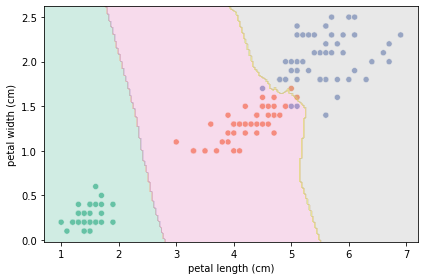

In [79]:
# COMPLETAR
plt.figure()
ax = sns.scatterplot(X.iloc[:,0], X.iloc[:,1], hue=y.values, palette='Set2')
plt.legend().remove()


xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
plt.tight_layout()
# plt.savefig('arbol_iris.png', dpi = 400)
plt.show()

8. ¿Qué ocurre con el desempeño a medida que modificas el número de vecinos?¿Y con las fronteras de decisión obtenidas? Mira en particular qué ocurre con número de vecinos igual a 1 y al tamaño del dataset (150).

9. Vuelve a entrenar, pero esta vez agregando más features a `X`. ¿Mejora o empeora el desempeño?

## 2. Construcción de un árbol de decisión *a mano*

Es raro que, como Data Scientist, tengas que programar un modelo, al menos en esta etapa de tu carrera. En general, existen muchas librerías con implementaciones de diferente métodos al alcance de la mano. Sin embargo, hacer una implementación rápida, aunque sea sencilla, ayuda comprender mejor algunos detalles. 

En esta sección vamos a programar la consulta de un árbol de decisión y, luego, calcular algunas impurezas Gini. Todo esto lo implementa Scikit-Learn de forma automática, pero hacerlo te ayudará a comprender mejor los árboles de decisión.

En la bitácora 07, Seaborn, te mencionamos brevemente el dataset de Titanic, que podías mirar en la competencia Kaggle Titanic: [Machine Learning from Disaster](https://www.kaggle.com/c/titanic). Hoy vamos a empezar a utilizarlo. En la descarga te dejamos una versión simplificada y filtrada de este dataset. Qué representa cada atributo puedes mirarlo en la página de Kaggle, pero te aclaramos que la columna `Sex`, en nuestro caso, refiere al género, donde `0` es hombre y `1` es mujer.

**Ejercicio:** Carga el dataset de Titanic y tomate un rato para estudiar sus características. 

In [80]:
# COMPLETAR
data = pd.read_csv('train.csv')

In [81]:
# COMPLETAR
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2.1 Árbol de decisión *a mano*

Ahora sí, manos a la obra.


**NOTA**: LEER HASTA EL FINAL ANTES DE MODIFICAR EL CÓDIGO.

En primer lugar, vamos a definir algunas funciones que serán de utilidad.

* La función `accuracy`, dada las etiquetas que ustedes predigan y las etiquetas reales, calcula la medida de performance, en este caso, la exactitud. **No la tienes que modificar, pero presta atención a su implementación**.

In [82]:
def accuracy(y_predicted, y_real):
    mask = np.array(y_predicted) == np.array(y_real)
    return mask.sum()/len(y_real)

* La función `predict_instance`, dada una instancia x con sus atributos, predice si sobrevivió o no. **Es la única función que tendrás que modificar**.

In [83]:
def predict_instance(x):
    '''
    Modificar las siguientes líneas de codigo. 
    Este será su algoritmo algoritmo para predecir si sobrevivirá o no por instancia.
    La variable prediction debe contener la etiqueta 0 o 1 
    
    Algunas opciones son: predecir que nadie sobrevivio, que todos sobrevivieron,
    predecir al azar, y usar lo aprendido cuando exploramos el dataset de Titanic
    '''
    prediction = 0
    
    ### UNA POSIBLE FORMA DE EMPEZAR:
    if x.Age < 12 or x.Sex=='female':
         prediction = 1
    else:
         prediction = 0
     # FIN DE COMPLETAR

    return prediction

* Por último, la función `predict` toma todo las instancias `X` y, usando la función que definieron antes, predice para cada una de ellas si sobrevivió o no. **No la tienes que modificar, pero presta atención a su implementación**.

In [84]:
def predict(X):
    y_predicted = []
    for x in X.itertuples(): 
        y_i = predict_instance(x) 
        y_predicted.append(y_i)
    return y_predicted

**Consigna**

1. Cargar el dataset de Titanic y separar en una variable `X` los atributos que usarás para predecir, y en una variable `y` la etiqueta que quieres predecir. En este caso, si sobrevivió o no.

In [85]:
X = data[['Age','Sex']]
y = data['Survived']

2. Usar los datos `X` para predecir si los pasajeros sobrevivieron o no utilizando la función `predict`. **No tienes que modificar ninguna de las funciones por ahora**.

In [86]:
y_pred = predict(X)
print(y_pred)

[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 

3. Calcula la medida de performance entre las etiquetas reales `y` y las etiquetas predichas `y_pred` con la función `accuracy`.

In [87]:
# COMPLETAR
accuracy(y_pred,y)

0.7912457912457912

4. Calcula la matriz de confusión con Scikit-Learn.

In [88]:
# COMPLETAR
from sklearn.metrics import confusion_matrix
confusion_matrix(y,y_pred)

array([[452,  97],
       [ 89, 253]])

**Ejercicio**: modifica `predict_instance` de forma tal de mejorar el resultado recién obtenido. Tal vez te sirva de pista, para arrancar, la famosa frase, "mujeres y niños primero".

**Para pensar:** las performances asociadas a predecir todos `0` (nadie sobrevivió), todos `1` (todos sobrevivieron), y predecir al azar son muy importantes para evaluar nuestro trabajo. ¿Por qué?

### 2.2 Cálculo de Impureza y Ganancia Gini

Ahora vamos a calcular cuán buena es la *pregunta* del género y clase para separar las muestras usando la impureza Gini. Para ello:

**Ejercicio:** calcula la impureza inicial del dataset. Ayuda: recuerda que en la variable `y` ya separaste las etiquetas. Si es un objeto de Pandas, tal vez la función `value_counts()` puede ser útil. 

In [89]:
muestras_neg, muestras_pos = y.value_counts()
N = y.size
gini_inicial = 1 - (muestras_neg/N)**2 - (muestras_pos/N)**2

In [90]:
print(gini_inicial)

0.4730129578614428


**Ejercicio:** calcula la impureza Gini luego de separar por el género. Recuerda que tienes que calcular la impureza en dos hojas - una correspondiente a género masculino y otra al femenino - y luego hacer un promedio ponderado. Para eso, puede ser conveniente crear una máscara y reciclar código anterior.

In [91]:
mascara = data.Sex=='female'
y_female = y[mascara]
y_male = y[~mascara]

In [92]:
# COMPLETAR
muestras_neg, muestras_pos= y_female.value_counts()
# COMPLETAR
N= y_female.size
gini_female = 1- (muestras_neg/N)**-(muestras_pos/N)**2
print(gini_female)

-0.02005218530506392


In [93]:
# COMPLETAR
muestras_neg, muestras_pos= y_male.value_counts()
N= y_male.size
gini_male= 1-(muestras_neg/N)**2-(muestras_pos/N)**2
print(gini_male)

0.3064437162277842


In [94]:
print('Impureza Gini al separar por Genero:',(y_female.size*gini_female + y_male.size*gini_male)/y.size)

Impureza Gini al separar por Genero: 0.19138230985144938


**Ejercicio Opcional:** calcula la impureza Gini luego de separar por clase. Recuerda que tienes que calcular la impureza en tres hojas y luego hacer un promedio ponderado. Para eso, puede ser conveniente crear tres máscaras y reciclar código anterior.

In [96]:
# PRIMERA CLASE
mascara = data.Pclass == 1
y_1 = y[mascara]

In [97]:
muestras_neg, muestras_pos = y_1.value_counts()
N = y_1.size
gini_1 = 1-(muestras_neg/N)**2-(muestras_pos/N)**2
print(gini_1)

0.46639231824417005


In [98]:
# SEGUNDA CLASE
mascara = data.Pclass==2
y_2 = y[mascara]

In [99]:
# COMPLETAR
muestras_neg, muestras_pos= y_2.value_counts()
N= y_2.size
gini_2 = 1-(muestras_neg/N)**2-(muestras_pos/N)**2
print(gini_2)

0.49852315689981097


In [100]:
# COMPLETAR - TERCERA CLASE
mascara = data.Pclass==3
y_3 = y[mascara]
muestras_neg, muestras_pos= y_3.value_counts()
N= y_3.size
gini_3 = 1-(muestras_neg/N)**2-(muestras_pos/N)**2
print(gini_3)

0.3672458634234966


In [101]:
print('Impureza Gini al separar por clase:', (y_1.size*gini_1 + y_2.size*gini_2 + y_3.size*gini_3)/y.size)

Impureza Gini al separar por clase: 0.4183913810900592


**¿Cuál tiene una mayor ganancia Gini?¿Concuerda con lo visto hasta ahora?**

**Para pensar:** ¿cómo modificarías el código para calcular la ganancia Gini al separar por edad? Por ejemplo, al separar por mayor de 12 años y menor de 12 años.

### 3. Titanic + Árboles de Decisión en Scikit-Learn

Si todavía te quedan energías, entrena un árbol de decisión de Scikit-Learn en el dataset de Titanic. Para ello, recibla código de este notebook y del anterior. Algunas recomendaciones:
1. Experimenta con distintas profundidades y visualizar el árbol obtenidos con la función `plot_tree` del módulo `tree` de Scikit-Learn.
1. Evalúa su desempeño calculando la exactitud y viendo su matriz de confusión.
1. Observa la importancia asignada a cada atributo (`feature_importances_`). En el notebook anterior podrás encontrar el código para realizar un gráfico de barras que te puede ser útil.
1. Si seleccionas dos atributos, pueden observar las fronteras de decisión.

¿Te parece que lo obtenido concuerda con lo que esperabas?¿Qué puedes aprender de la tragedia del Titanic viendo el árbol de decisíon y la importancia de cada atributo (feature)?

In [103]:
# Creamos un objeto arbol
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2, random_state = 42)

In [108]:
data= pd.read_csv('ds_12_titanic.csv')

X = data[['Age','Sex']]
y = data['Survived']

clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [109]:
# Predecimos sobre nuestro set
y_pred = clf.predict(X)

# Comaparamos con las etiquetas reales
print('Accuracy:', accuracy_score(y_pred,y))

Accuracy: 0.7913165266106442


In [110]:
confusion_matrix(y, y_pred)

array([[352,  72],
       [ 77, 213]])

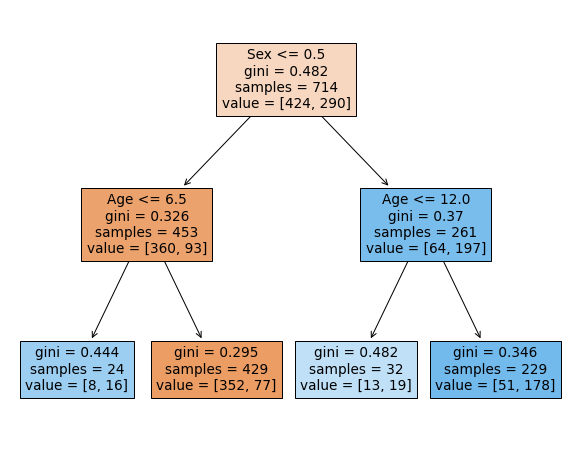

In [112]:
from sklearn import tree

plt.figure(figsize = (10,8))
tree.plot_tree(clf, filled = True, feature_names= X.columns)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


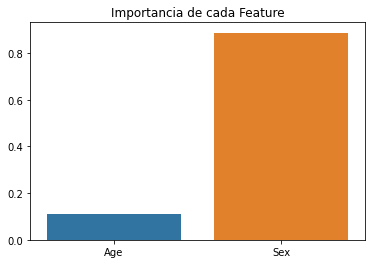

In [113]:
importances = clf.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.show()